# 1. 算法介绍

在过去的十年里，数据科学、人工智能（AI）和机器学习（ML）显著提升了足球分析过程。这些创新通过提供实时统计数据，改变了评估体育团队和运动员表现的传统方法的观点。以往多依赖于人的直觉和感性认知，而计算型足球分析可以访问广泛的跟踪、事件和生物测量数据，这些数据中的行为模式几乎难以被教练和运动员察觉。 

如今，足球大数据涵盖了广泛的应用范围，从球员监测到战术策略，甚至包括比赛预测及伤病风险。借助诸如计算机视觉和穿戴技术等多种手段，可以详细记录球员的移动、速度和加速度等信息。机器学习算法随后处理这些信息，以实现实时应用中的个人和团队效率评估。战术决策也因AI生成的比赛情况和选择正确战术的可能性而拓展，这包括赛前和赛中的战术判断。最新的自动事件检测系统甚至能够识别重要的比赛发生，如进球、犯规或抢断，并提供关键时刻所需的教练和分析师所需的信息。

在机器视觉中有众多不同任务，包括了图像分类(Image Classification) 、目标检测（Object Detection）和图像分割（Segmentation）。在足球运动场景分析中，需要捕捉个体的类别和位置信息，属于目标检测任务。

目标检测作为计算机视觉中的核心任务之一，旨在 同时定位图像中的目标（bounding box）并分类（object category）。与图像分类相比，目标检测不仅识别图片中“是什么”，还指出“在哪里”。



## 1.1 目标检测

目标检测有一阶段和二阶段目标检测器：

二阶段：候选区域提取 -> 特征提取 -> 分类回归

一阶段：直接使用 CNN 提取特征 -> 同时回归位置 + 分类

|分类|方法代表|检测流程|特点|
|---|---|---|---|
|二阶段|R-CNN，Fast R-CNN|首先提取候选框再分类和回归|精度高，但是速度慢|
|一阶段|YOLO，SSD|直接从图像中回归目标位置和类别|结构简洁速度快，但是精度不如二阶段|

可见，足球运动员目标检测作为一个高实时性的任务，可以采用一阶段的方法。


## 1.2 YOLO 的核心思想

YOLOv1 在 2016 年被首次提出，由 Joseph Redmon 以论文形式发表，作为单阶段目标检测算法，直接提取出图像中存在物体的位置锚框与类别。首先会划分出若干份子区域，通过特征的提取与蒸馏得到子区域数量的特征向量，这个向量有明显的可读结构。

特征提取结构：

![image.png](https://raw.githubusercontent.com/HolmesAmzish/NotesOfCacc/refs/heads/master/ArtififialIntellegence/ComputerVision/assets/image-20250705134626015.png)

模型接受的输入大小是 $448 \times 448 \times 3$，输出为 $7 \times 7 \times 30$，中间经过了卷积与池化。最后化为 $7 \times 7 \times 30$ 的张量，也就是最终提取出来的最终特征。其中最终的向量被看作 $S \times S \times (5 \times B + C)$，$S \times S$ 为图像被分割的区域数，$5 \times B $为锚框特征。分别为坐标，边框长宽与有物体的信心。
$$
\underbrace{(x, y, w, h, \text{objectness})}_{\text{5个参数}} \times B = 5B
$$
损失函数：
$$
\begin{equation}
\begin{split}
\mathcal{L} &= \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{obj}} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 \right] \\
&+ \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{obj}} \left[ (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2 \right] \\
&+ \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{obj}} (C_i - \hat{C}_i)^2 \\
&+ \lambda_{\text{noobj}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{noobj}} (C_i - \hat{C}_i)^2 \\
&+ \sum_{i=0}^{S^2} \mathbb{1}_{i}^{\text{obj}} \sum_{c \in \text{classes}} (p_i(c) - \hat{p}_i(c))^2
\end{split}
\end{equation}
$$
可以明显看出，YOLOv1的损失函数可以分为五个分项：

1. 预测框中心坐标与真实框的均方误差（MSE）
2. 对宽度 $w_i$ 和高度 $h_i$ 取平方根后的 MSE
3. 有目标的边界框的置信度与真实值的 MSE
4. 无目标的边框的置信度与真实值的 MSE
5. 每个网络的类别概率与真实类别

![image.png](https://raw.githubusercontent.com/HolmesAmzish/NotesOfCacc/refs/heads/master/ArtififialIntellegence/ComputerVision/assets/image-20250730211716453.png)

提取到子区域的特征后，利用非极大值抑制（Non-Maximum Suppression，NMS）算法对所有候选边界框进行筛选。NMS通过比较每个预测框的置信度分数，保留置信度较高的框，并剔除与之高度重叠的低置信度框，从而有效去除重复检测和冗余框。最终，经过NMS处理后，得到一组置信度较高且位置准确的目标边界框，作为最终检测结果。


## 1.3 YOLO 的发展与应用

YOLO（You Only Look Once）自 2016 年提出以来，凭借其端到端、实时性强的特性，成为目标检测领域最具影响力的算法之一。

从 YOLOv1 到 YOLOv4，原作者 Joseph Redmon 团队始终使用自研的 Darknet 框架，该框架基于 C 与 CUDA 编写，专为高效训练与推理设计。这些版本均以学术论文形式正式发表，逐步推动 YOLO 系列的成熟与优化。

在 YOLOv4 发布后，原作者因伦理和社会问题宣布退出计算机视觉研究。此后，YOLO 项目进入了由社区维护的发展阶段。

其中最具代表性的是由 Ultralytics 团队 开发和维护的 YOLOv5、YOLOv8、YOLOv11 等版本。这些版本采用 PyTorch 深度学习框架重构，实现了更强的可扩展性、易用性与部署灵活性。Ultralytics 不仅优化了网络结构和性能，还提供了清晰的 API 和丰富的文档，使得 YOLO 更容易在工业界与学术界广泛应用。

这些版本已广泛用于安防监控、自动驾驶、体育分析、智慧城市等多个实际场景中，展示了极高的工程价值和商业潜力。

# 2. 利用 YOLOv5 对足球场景下的目标检测应用


## 2.1 实验介绍

本实验旨在基于深度学习方法，探索和实现足球场景下的目标检测任务，识别包括球员、守门员、裁判以及足球在内的多类目标。目标检测在体育分析中具有广泛应用，能够为战术分析、自动集锦生成、智能裁判等提供关键技术支撑。

考虑到模型稳定性、社区支持和开发便捷性，我们选择使用由 Ultralytics 团队维护的 YOLOv5 作为目标检测框架。YOLOv5 以 PyTorch 实现，支持灵活的训练、推理和部署方式，并提供丰富的文档与预训练模型，适合快速实验和优化。

本实验将围绕以下几个核心方面展开：

类别不平衡问题的应对策略：在足球场景中，不同目标出现频率差异明显（如球员较多，足球较少），我们将探讨如何通过数据增强、类别加权等方法缓解这一问题。

完整的模型训练与评估流程：涵盖数据预处理、训练参数设定、损失函数分析、模型性能评估指标（如mAP、Recall、Precision）以及训练结果可视化。

模型优化与实际场景适配：通过超参数调整、迁移学习、误检分析等手段提升模型在真实环境中的表现，并探讨其在自动标注、视频分析中的实际应用潜力。

数据集介绍
本实验所用数据集来自 (Kaggle - Football Players Detection Dataset)[https://www.kaggle.com/datasets/borhanitrash/football-players-detection-dataset]。该数据集包含标注完整的图像文件，目标类别包括：

- Player（球员）

- Goalkeeper（守门员）

- Referee（裁判）

- Ball（足球）

图像场景涵盖多个视角和比赛环境，适合作为多目标检测算法的训练与测试基础。

## 2.2 准备工作

需要首先下载依赖和引用。通过 pip 安装并导入。其中 torch 等常用环境在服务器上已经默认安装

In [1]:
%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import glob
from IPython.display import display, Image
import numpy as np
import yaml
from PIL import Image as PILImage
import albumentations as A
import shutil
from pathlib import Path

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# 配置基础路径
main_path = '/kaggle/input/football-players-detection-dataset'
data_yaml_path = '/kaggle/input/football-players-detection-dataset/data.yaml'
class_names = ["ball", "goalkeeper", "player", "referee"]  # 四种类别
work_dir = '/kaggle/working/football_detection_improved'
os.makedirs(work_dir, exist_ok=True)  # 创建工作目录

## 2.3 数据集分析

在开始机器视觉模型的训练任务之前，首要的一步是对所使用的数据集进行深入分析。数据集不仅决定了模型的训练效果和泛化能力，也直接影响到数据预处理、模型架构选择、训练策略等多个环节。

目前主流的目标检测数据集有多种组织方式，其中较为常见的包括 **Pascal VOC** 格式 和 **YOLO** 格式。这两种格式在数据标注、文件结构和标签表示方式上各有特点。例如，Pascal VOC 使用的是 XML 文件进行标注，而 YOLO 则采用简洁的文本文件格式，并使用归一化的坐标表示目标位置。这种差异源于各自模型的输入输出结构。例如，YOLO 模型是一种端到端的实时检测网络，其特定的输出结构要求输入数据集必须按照特定格式组织，以适配网络的训练过程。

除了数据格式，分析数据集的内容和分布同样重要。我们需要重点关注以下几个方面：

- 类别分布是否均衡：如果某些类别样本数量过多而其他类别样本稀少，容易导致模型训练时产生偏倚（bias），影响小样本类别的检测效果。

- 图像的分辨率和尺寸差异：图像尺寸是否统一，将影响模型输入的处理方式，如是否需要缩放、裁剪或填充。

- 目标在图像中的尺寸与位置：目标过小、过大或密集排列时，对模型的检测能力提出了更高要求。

- 数据增强策略的适配性：了解原始数据的特点，有助于设计合适的数据增强方法（如旋转、翻转、颜色扰动等），提高模型的泛化能力。

对数据集的全面分析不仅帮助我们理解现有数据的优劣，还能指导后续的模型设计和训练流程，为构建高性能的视觉系统打下坚实基础。

数据集配置信息:
类别数量: 4
类别名称: ['ball', 'goalkeeper', 'player', 'referee']
训练集路径: ../train/images
验证集路径: ../valid/images
测试集路径: ../test/images


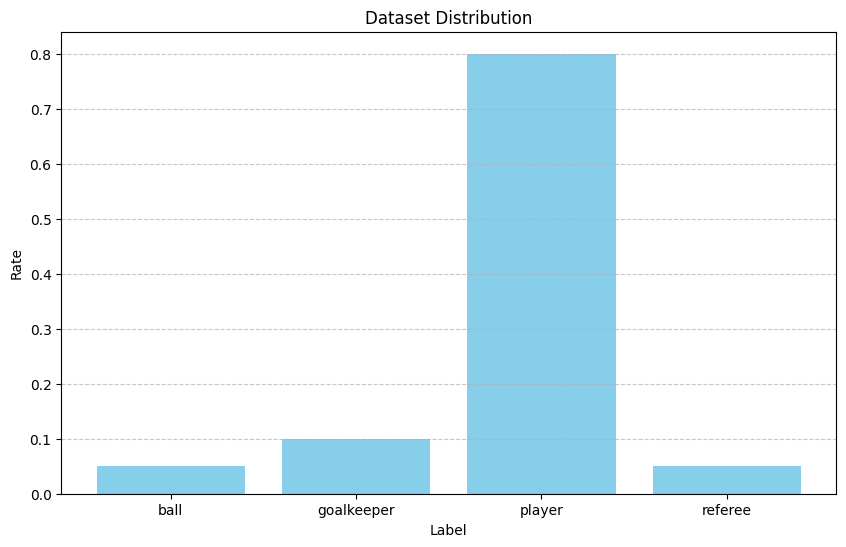

In [4]:
# 读取并分析数据集配置文件
with open(data_yaml_path, 'r') as file:
    data_cfg = yaml.safe_load(file)
    
print("数据集配置信息:")
print(f"类别数量: {data_cfg['nc']}")
print(f"类别名称: {data_cfg['names']}")
print(f"训练集路径: {data_cfg['train']}")
print(f"验证集路径: {data_cfg['val']}")
print(f"测试集路径: {data_cfg.get('test', '未指定')}")

# 可视化类别的分布统计
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(class_names, [0.05, 0.1, 0.8, 0.05], color='skyblue')
ax.set_title('Dataset Distribution')
ax.set_ylabel('Rate')
ax.set_xlabel('Label')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

从上面的分布图可以看出：

- 球员(player) 类别占比最大（约80%）
- 足球(ball) 和 裁判(referee) 占比很小（各约5%）
- 守门员(goalkeeper) 约占10%

这种不平衡会导致模型对小样本类别检测效果较差。我们将在后续通过**类别加权**和**数据增强**解决这个问题。

## 2.4 数据预处理

手动创建一个带权重的数据集设置文件，调整样本不平衡的问题。

In [5]:
# 创建带类别加权的自定义配置文件
custom_data_yaml = os.path.join(work_dir, 'custom_data.yaml')
with open(data_yaml_path, 'r') as infile, open(custom_data_yaml, 'w') as outfile:
    data = yaml.safe_load(infile)
    # 设置类别权重 - 罕见类别获得更高权重
    data['class_weights'] = [5.0, 3.0, 1.0, 4.0]  # [ball, goalkeeper, player, referee]
    yaml.dump(data, outfile)

本实验针对足球场景下目标类别分布不均的情况，设计了类别感知的数据增强策略，重点对包含稀有类别（如足球、守门员、裁判）的图像进行多种图像增强（如翻转、模糊、雾化等），生成更多样本以提升模型识别稀有目标的能力，并构建符合YOLO训练格式的增强数据集用于后续训练。

In [6]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.RandomScale(scale_limit=0.2, p=0.4),
    A.MotionBlur(blur_limit=5, p=0.3),  # 运动模糊增强
    A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=0.2)  # 雾化效果
], bbox_params=A.BboxParams(format='yolo'))

def create_augmented_dataset():
    """创建数据集的副本并对稀有类别（ball，goalkeeper，referee）进行数据增强"""

    # 创建增强数据集的目录
    aug_dir = os.path.join(work_dir, 'augmented_dataset')

    # 创建符合YOLOv5/v8规范的目录结构
    train_images_dir = os.path.join(aug_dir, 'train', 'images')
    train_labels_dir = os.path.join(aug_dir, 'train', 'labels')
    val_images_dir = os.path.join(aug_dir, 'valid', 'images')  # 目录名必须是"valid"而非"val"
    val_labels_dir = os.path.join(aug_dir, 'valid', 'labels')

    # 创建必要的文件夹
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)

    # 复制原始训练数据和增强数据
    train_img_dir = os.path.join(main_path, 'train', 'images')
    train_label_dir = os.path.join(main_path, 'train', 'labels')

    img_files = sorted(glob.glob(os.path.join(train_img_dir, '*.*')))
    print(f"找到 {len(img_files)} 张原始训练图片")


    # 复制并增强训练文件
    for img_path in img_files:
        img_name = os.path.basename(img_path)
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(train_label_dir, label_name)

        # 复制原始图片和标签文件
        shutil.copy(img_path, os.path.join(train_images_dir, img_name))
        shutil.copy(label_path, os.path.join(train_labels_dir, label_name))

        # 读取标签内容，判断是否包含稀有类别
        with open(label_path, 'r') as f:
            labels = f.readlines()

        has_rare_class = False
        for label in labels:
            class_id = int(label.split()[0])
            if class_id in [0, 1, 3]:  # ball(0), goalkeeper(1), referee(3)
                has_rare_class = True
                break

        # 如果包含稀有类别，则进行数据增强
        if has_rare_class:
            img = np.array(PILImage.open(img_path))

            # 每张包含稀有类别的图片创建3个增强版本
            for i in range(3):
                augmented = transform(image=img)
                aug_img = augmented['image']

                # 保存增强后的图片
                aug_img_name = f"aug_{i}_{img_name}"
                PILImage.fromarray(aug_img).save(os.path.join(train_images_dir, aug_img_name))

                # 复制标签（假设增强过程不改变目标位置）
                aug_label_name = f"aug_{i}_{label_name}"
                shutil.copy(label_path, os.path.join(train_labels_dir, aug_label_name))

    # 复制原始验证数据
    val_img_dir = os.path.join(main_path, 'valid', 'images')
    val_label_dir = os.path.join(main_path, 'valid', 'labels')

    val_files = sorted(glob.glob(os.path.join(val_img_dir, '*.*')))
    print(f"找到 {len(val_files)} 张原始验证图片")

    # 复制所有验证文件
    for img_path in val_files:
        img_name = os.path.basename(img_path)
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(val_label_dir, label_name)

        shutil.copy(img_path, os.path.join(val_images_dir, img_name))
        if os.path.exists(label_path):  # 如果标签存在则复制
            shutil.copy(label_path, os.path.join(val_labels_dir, label_name))

    # 更新 data.yaml 文件，指向新的数据路径
    aug_data_yaml = os.path.join(aug_dir, 'data.yaml')
    with open(custom_data_yaml, 'r') as infile, open(aug_data_yaml, 'w') as outfile:
        data = yaml.safe_load(infile)
        data['train'] = train_images_dir  # 更新训练集路径
        data['val'] = val_images_dir      # 更新验证集路径
        data['path'] = aug_dir            # 更新根目录路径
        data['names'] = class_names       # 确保类别名称正确
        data['nc'] = len(class_names)     # 类别数
        yaml.dump(data, outfile)

    return aug_data_yaml

In [7]:
augmented_data_yaml = create_augmented_dataset()

找到 250 张原始训练图片
找到 43 张原始验证图片


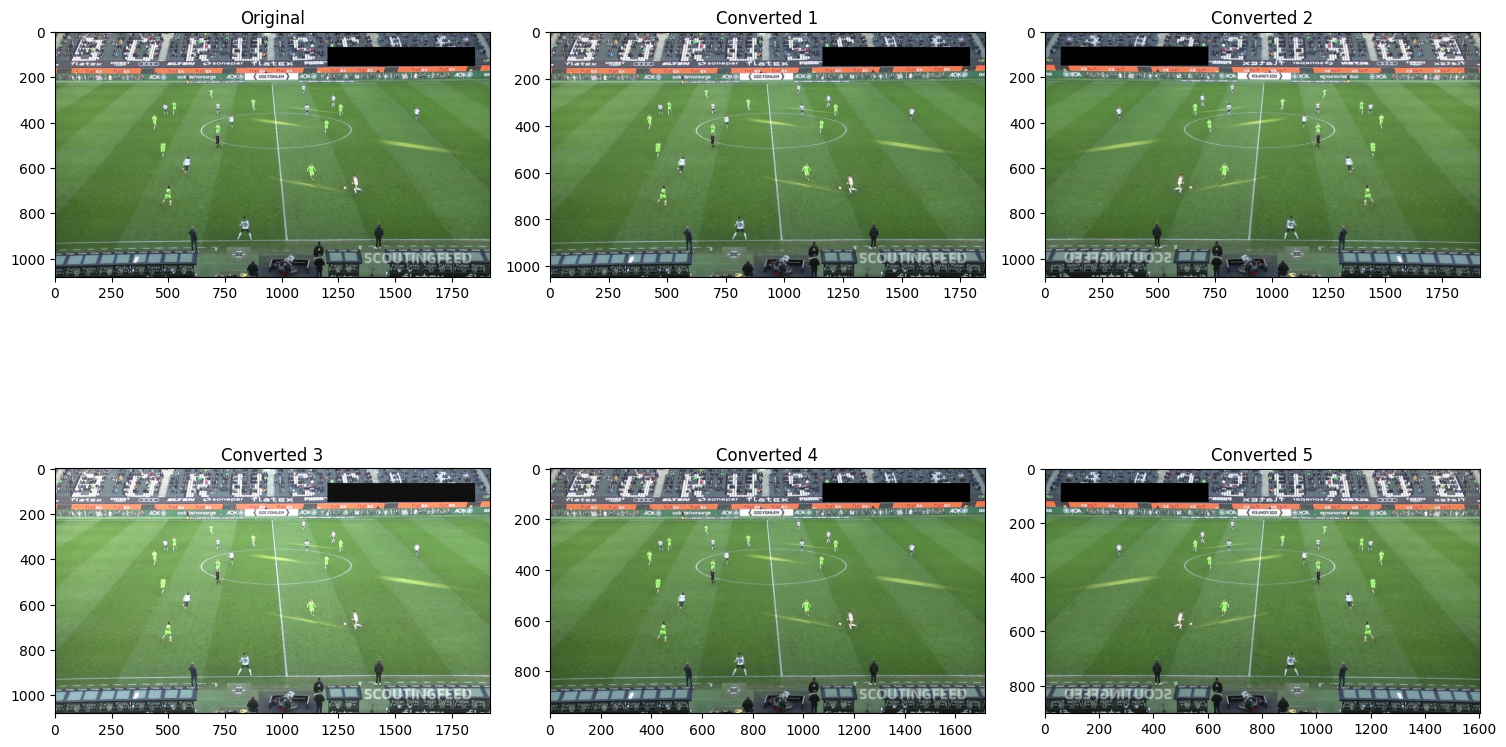

In [8]:
# 可视化增强效果
sample_img_path = glob.glob(os.path.join(main_path, 'train/images/*.jpg'))[0]
img = np.array(PILImage.open(sample_img_path))

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(img)
axs[0, 0].set_title('Original')

for i in range(5):
    augmented = transform(image=img)
    axs[(i+1)//3, (i+1)%3].imshow(augmented['image'])
    axs[(i+1)//3, (i+1)%3].set_title(f'Converted {i+1}')

plt.tight_layout()
plt.show()

In [9]:
print("\n检查YAML的内容:")
with open(augmented_data_yaml, 'r') as f:
    print(f.read())


检查YAML的内容:
class_weights:
- 5.0
- 3.0
- 1.0
- 4.0
names:
- ball
- goalkeeper
- player
- referee
nc: 4
path: /kaggle/working/football_detection_improved/augmented_dataset
roboflow:
  license: CC BY 4.0
  project: football-players-detection-3zvbc
  url: https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/dataset/9
  version: 9
  workspace: roboflow-jvuqo
test: ../test/images
train: /kaggle/working/football_detection_improved/augmented_dataset/train/images
val: /kaggle/working/football_detection_improved/augmented_dataset/valid/images



## 2.5 模型训练设置

首先设置全局静态变量，这些参数控制训练过程的关键方面，等会训练时会用到

|参数|描述|
|---|---|
|IMG_SIZE| 输入图像尺寸，越大精度越高计算开销越大|
|EPOCH| 训练轮数|
|BATCH_SIZE| 批处理大小，受 GPU 显存限制|
|LEARNING_RATE| 学习率，权重更新的步长|
|WEIGHT_DECAY| 权重衰减，防止过拟合|
|CONF_THRESHOLD| 置信度阈值|
|NMS_IOU_THRESHOLD| 非极大值抑制的IoU阈值，消除重叠框|

除了基础的模型训练设置，YOLOv8 还内置了许多增强方法来提升模型鲁棒性，本配置还针对足球场景进行了增强
|增强类型|		作用|足球场景必要性|
|---|---|---|
|Mosaic|	四图拼接，提升小目标（足球）检测及复杂背景适应性|	解决远场足球尺度小、球员遮挡问题|
|MixUp|		图像混合，模拟球员与足球重叠场景，增强遮挡鲁棒性|	减少球员身体遮挡导致的足球漏检|
|Copy-Paste|	复制粘贴目标，平衡稀有类别（裁判、足球）样本分布|	裁判样本稀少，需人工合成训练数据|
|Horizontal Flip|	水平翻转，学习对称特征（如球员左右跑动）|	提升模型对球场左右半场的无偏识别|
|Random Scale|尺度抖动（±25%），适应摄像机变焦导致的球体大小变化	|解决近景足球大、远景足球小的尺度差异|
|Rotation|	小幅旋转（±5°），应对摄像机倾斜或球员倾斜|	避免极端旋转导致球体形变失真|


In [10]:
MODEL_VARIANT = 'yolov5s'

IMG_SIZE = 1280
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005
CONF_THRESHOLD = 0.25
NMS_IOU_THRESHOLD = 0.5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- 修改部分：使用 ultralytics.YOLO 类加载 YOLOv5 模型 ---
# 不再使用 torch.hub.load，而是直接使用 ultralytics 提供的 YOLO 类
# 该类会自动下载正确的 YOLOv5 .pt 权重，并提供标准的 .train() 接口
try:
    # 构建完整的模型名称，带有 .pt 扩展名，用于 YOLOv5 权重
    model_name = f'{MODEL_VARIANT}.pt'
    model = YOLO(model_name)  # 如果本地不存在，将会自动下载 yolov5s.pt
    model.to(DEVICE)
    print(f"成功使用 ultralytics.YOLO 类加载 YOLOv5 模型: {model_name}")
except Exception as e:
    print(f"使用 ultralytics.YOLO 加载 YOLOv5 模型时出错: {e}")
    print("请确保 'ultralytics' 库已正确安装并可访问。")

train_args = {
    'data': augmented_data_yaml,
    'epochs': EPOCHS,
    'imgsz': IMG_SIZE,
    'batch': BATCH_SIZE,
    'device': DEVICE,
    'project': work_dir,
    'name': 'yolov5_football_detection_improved',
    'weight_decay': WEIGHT_DECAY,
    'lr0': LEARNING_RATE,
    'lrf': 0.01,
    'mosaic': 1.0,
    'mixup': 0.2,
    'fliplr': 0.5,
    'scale': 0.25,
    'degrees': 5.0,
    'patience': 15,
    'save_period': 5,
    'exist_ok': True,
    # 'cache': 'ram',  # 可选：缓存数据到内存
    # 'workers': 8,    # 可选：设置数据加载线程数
}

# 使用字典解包方式调用 train 方法
results_train = model.train(**train_args)

print("\n--- 训练完成 ---")
print(f"训练结果保存路径的示例: {work_dir}/yolov5_football_detection_improved")


Using device: cuda
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

成功使用 ultralytics.YOLO 类加载 YOLOv5 模型: yolov5s.pt
Ultralytics 8.3.177 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/football_detection_improved/augmented_dataset/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, img

train: Scanning /kaggle/working/football_detection_improved/augmented_dataset/train/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<00:00, 1035.64it/s]


train: New cache created: /kaggle/working/football_detection_improved/augmented_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1252.8±1000.6 MB/s, size: 218.3 KB)


val: Scanning /kaggle/working/football_detection_improved/augmented_dataset/valid/labels.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/football_detection_improved/yolov5_football_detection_improved/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to /kaggle/working/football_detection_improved/yolov5_football_detection_improved
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.63G      1.359       1.86      1.021        307       1280: 100%|██████████| 125/125 [01:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]

                   all         43       1025      0.746      0.705      0.731      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.91G      1.272      1.374     0.9696        362       1280: 100%|██████████| 125/125 [01:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


                   all         43       1025      0.819       0.73      0.796      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      9.56G      1.255      1.317     0.9645        408       1280: 100%|██████████| 125/125 [01:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


                   all         43       1025      0.847      0.798      0.838      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.4G      1.209      1.277     0.9528        266       1280: 100%|██████████| 125/125 [01:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


                   all         43       1025      0.903      0.729      0.842      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.85G      1.211      1.274     0.9514        282       1280: 100%|██████████| 125/125 [01:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


                   all         43       1025      0.932      0.762      0.844      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      9.35G      1.212      1.252     0.9542        322       1280: 100%|██████████| 125/125 [01:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


                   all         43       1025      0.896      0.777      0.841      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.55G      1.189      1.239      0.945        366       1280: 100%|██████████| 125/125 [01:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]


                   all         43       1025      0.889       0.78      0.849      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      9.01G      1.154       1.16     0.9349        352       1280: 100%|██████████| 125/125 [01:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

                   all         43       1025      0.877       0.81      0.858      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      9.26G      1.147      1.162     0.9334        302       1280: 100%|██████████| 125/125 [01:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

                   all         43       1025      0.868      0.781      0.843      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      9.59G      1.147       1.16     0.9332        415       1280: 100%|██████████| 125/125 [01:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


                   all         43       1025      0.891      0.814      0.871      0.593
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.21G      1.101      1.201     0.9251        183       1280: 100%|██████████| 125/125 [01:04<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         43       1025      0.851      0.795      0.855      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.21G      1.088      1.184     0.9193        183       1280: 100%|██████████| 125/125 [01:02<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


                   all         43       1025       0.91      0.794      0.847      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.21G       1.07      1.181     0.9179        186       1280: 100%|██████████| 125/125 [01:02<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

                   all         43       1025      0.909      0.802      0.863      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.21G      1.052      1.158     0.9138        187       1280: 100%|██████████| 125/125 [01:02<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

                   all         43       1025      0.918      0.812       0.88      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.21G       1.04       1.17     0.9129        190       1280: 100%|██████████| 125/125 [01:03<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


                   all         43       1025      0.879       0.82      0.859      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.21G       1.03      1.134     0.9093        189       1280: 100%|██████████| 125/125 [01:03<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


                   all         43       1025      0.941      0.816       0.87      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.21G      1.025      1.127     0.9084        189       1280: 100%|██████████| 125/125 [01:03<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


                   all         43       1025       0.95      0.804      0.875      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.21G       1.01      1.124     0.9069        186       1280: 100%|██████████| 125/125 [01:03<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


                   all         43       1025       0.94      0.819      0.876      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.21G      0.981      1.079     0.9001        190       1280: 100%|██████████| 125/125 [01:03<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]


                   all         43       1025      0.954      0.823       0.87      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.21G     0.9933      1.124     0.9056        183       1280: 100%|██████████| 125/125 [01:03<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         43       1025       0.95      0.802      0.871      0.617



20 epochs completed in 0.370 hours.
Optimizer stripped from /kaggle/working/football_detection_improved/yolov5_football_detection_improved/weights/last.pt, 18.6MB
Optimizer stripped from /kaggle/working/football_detection_improved/yolov5_football_detection_improved/weights/best.pt, 18.6MB

Validating /kaggle/working/football_detection_improved/yolov5_football_detection_improved/weights/best.pt...
Ultralytics 8.3.177 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 84 layers, 9,113,084 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         43       1025       0.95      0.802      0.871      0.615
                  ball         39         39      0.951      0.513      0.601      0.327
            goalkeeper         32         32      0.961       0.76      0.925       0.74
                player         43        853      0.963      0.985      0.985      0.755
               referee         43        101      0.926       0.95      0.975      0.638
Speed: 0.5ms preprocess, 10.7ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to /kaggle/working/football_detection_improved/yolov5_football_detection_improved

--- 训练完成 ---
训练结果保存路径的示例: /kaggle/working/football_detection_improved/yolov5_football_detection_improved


## 2.6 模型评估

同时通过验证集评估，是验证性能的关键步骤，使用验证集来评估模型的性能，输出关键的指标mAP和可视化结果如混淆矩阵。

Ultralytics 8.3.177 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 84 layers, 9,113,084 parameters, 0 gradients, 23.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3311.9±437.4 MB/s, size: 215.3 KB)


val: Scanning /kaggle/working/football_detection_improved/augmented_dataset/valid/labels.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         43       1025      0.963      0.779      0.874       0.65
                  ball         39         39       0.95      0.487      0.713      0.454
            goalkeeper         32         32      0.958      0.719      0.843      0.688
                player         43        853      0.986       0.98      0.988      0.801
               referee         43        101      0.959      0.931      0.953      0.657
Speed: 5.4ms preprocess, 31.9ms inference, 0.1ms loss, 12.3ms postprocess per image
Results saved to /kaggle/working/football_detection_improved/yolov5_football_detection_improved_val

--- 评估结果 ---
综合准确率 (mAP50-95): 0.6500
常用准确率 (mAP50): 0.8742

类别详细指标:
0: 精度=0.9500, 召回率=0.4872
1: 精度=0.9583, 召回率=0.7188
2: 精度=0.9858, 召回率=0.9801
3: 精度=0.9592, 召回率=0.9307


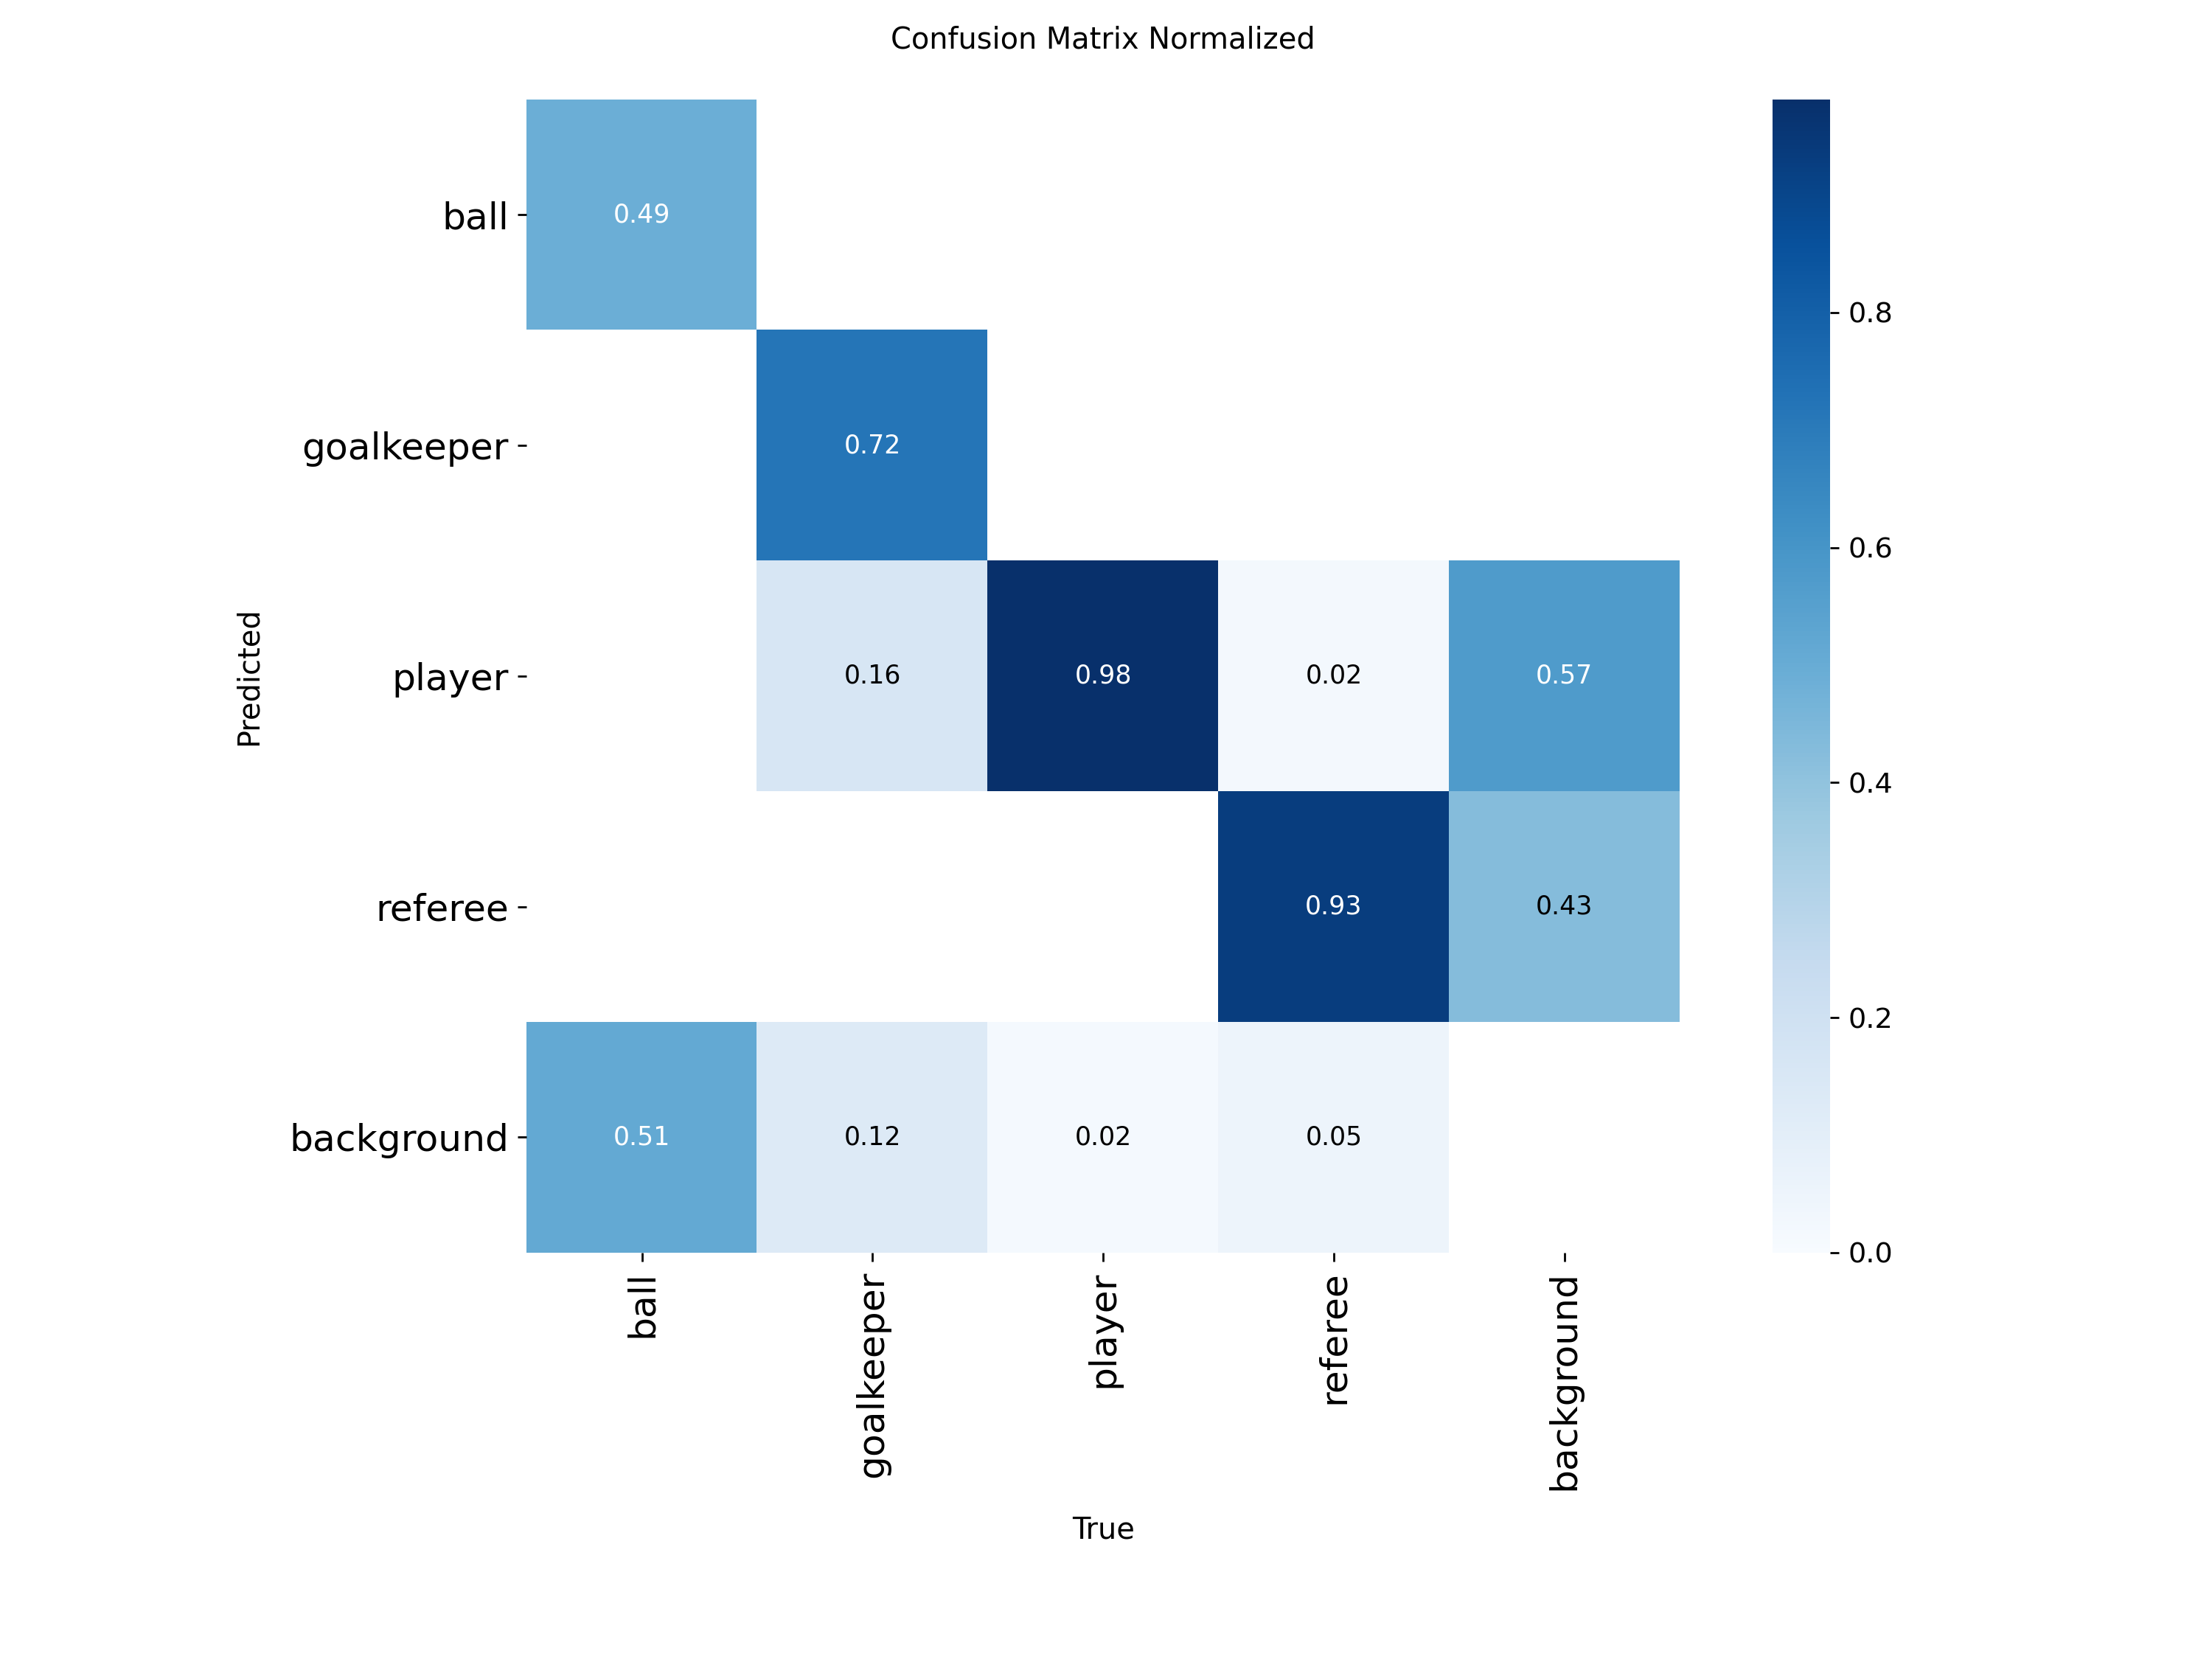

未找到结果图：/kaggle/working/football_detection_improved/yolov5_football_detection_improved_val/results.png


In [11]:
val_args = {
    'data': augmented_data_yaml,  # 指定数据配置文件路径
    # 'split': 'val', # YOLOv5 的 val 方法通常不需要显式指定 split 参数，会使用 data.yaml 中的信息
    'imgsz': IMG_SIZE,
    'batch': BATCH_SIZE,
    'conf': CONF_THRESHOLD,  # 置信度阈值
    'iou': NMS_IOU_THRESHOLD,  # NMS 的 IOU 阈值
    'device': DEVICE,
    'project': work_dir,
    'name': 'yolov5_football_detection_improved_val',
    'exist_ok': True,
    # 'verbose': True, # 可选：是否在评估过程中打印详细信息
}

# 使用字典解包方式调用 val 方法进行模型验证
results_val = model.val(**val_args)

print("\n--- 评估结果 ---")
# YOLOv5 的评估结果对象通常包含 box 属性（box.map, box.map50 等）
if hasattr(results_val, 'box'):
    print(f"综合准确率 (mAP50-95): {results_val.box.map:.4f}")
    print(f"常用准确率 (mAP50): {results_val.box.map50:.4f}")
    print("\n类别详细指标:")
    
    # 如果结果中包含精度 (precision, p) 和召回率 (recall, r)
    if hasattr(results_val.box, 'p') and hasattr(results_val.box, 'r'):
        # 尝试从模型中获取类别名称
        if hasattr(model, 'names') and model.names:
            class_names_from_model = model.names
        else:
            # 如果模型中无法获取类别名称，可以从 data.yaml 文件中加载
            print("警告：无法从 model.names 获取类别名称，如需打印详细指标，请手动定义 class_names 列表。")
            class_names_from_model = ['class_0', 'class_1', 'class_2', 'class_3']  # 占位符类别名称

        # 遍历每个类别，打印精度和召回率
        for i, class_name in enumerate(class_names_from_model):
            class_precision = results_val.box.p[i] if i < len(results_val.box.p) else float('nan')
            class_recall = results_val.box.r[i] if i < len(results_val.box.r) else float('nan')
            print(f"{class_name}: 精度={class_precision:.4f}, 召回率={class_recall:.4f}")
    else:
        print("无法直接访问按类别的精度和召回率。")
else:
    print("无法直接访问评估结果的 box 属性，请检查 YOLOv5 的 val 方法返回值类型。")
    # 可以打印整个结果对象以确认其结构
    # print(results_val)

# 构造混淆矩阵和评估结果图的路径
# YOLOv5 默认将评估结果保存在 project/name 目录下
val_save_dir = os.path.join(work_dir, 'yolov5_football_detection_improved_val')

# 导入所需库
import os
from IPython.display import Image, display

# 显示混淆矩阵图像（如果存在）
if os.path.exists(os.path.join(val_save_dir, 'confusion_matrix_normalized.png')):
    display(Image(filename=os.path.join(val_save_dir, 'confusion_matrix_normalized.png')))
else:
    print(f"未找到混淆矩阵图像：{os.path.join(val_save_dir, 'confusion_matrix_normalized.png')}")

# 显示整体评估指标图（如果存在）
if os.path.exists(os.path.join(val_save_dir, 'results.png')):
    display(Image(filename=os.path.join(val_save_dir, 'results.png')))
else:
    print(f"未找到结果图：{os.path.join(val_save_dir, 'results.png')}")


YOLOv8 自动生成的训练可视化图表提供了重要指标
|指标|含义|
|---|---|
|box_loss|边界框回归损失|
|cls_loss|类别分类损失|
|dfl_loss|分布式边界框回归损失|
|precision|精度|
|recall|召回率|
|mAP50|平均精度均值@IoU=0.5|
|mAP50-95|平均精度均值@IoU=0.5|

In [ ]:
display(Image(filename=os.path.join('/kaggle/working/football_detection_improved/yolov5_football_detection_improved/results.png')))

In [ ]:
def draw_boxes(image_path, boxes, scores, classes, class_names, color_map):
    """
    在图像上绘制边界框和标签。
    参数:
        image_path (str): 原始图像的路径。
        boxes (np.array): 边界框坐标，形状为 N x 4（xyxy格式）。
        scores (np.array): 检测置信度得分。
        classes (np.array): 类别ID。
        class_names (list): 类别名称列表。
        color_map (dict): 类别ID到颜色(RGB元组)的映射。
    返回:
        np.array: 绘制好边界框的图像（RGB格式）。
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"错误：无法读取图像 {image_path}，返回黑图。")
        # 如果图像读取失败，返回指定大小的黑色图像
        return np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8) 
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR转RGB，用于matplotlib显示

    for i in range(len(boxes)):
        x1, y1, x2, y2 = map(int, boxes[i])
        score = scores[i]
        cls_id = int(classes[i])
        
        # 确保类别ID在合法范围内
        if 0 <= cls_id < len(class_names):
            label = f"{class_names[cls_id]}: {score:.2f}"
            color = color_map.get(cls_id, (255, 0, 0))  # 如果未指定颜色，默认用红色
            
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        else:
            print(f"警告：类别ID {cls_id} 超出范围（class_names长度为 {len(class_names)}），跳过绘制。")

    return img

test_img_dir = os.path.join(main_path, 'test', 'images')
test_image_paths = sorted(glob.glob(os.path.join(test_img_dir, '*.*')))[:4]

if test_image_paths:
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    for i, img_path in enumerate(test_image_paths):
        # --- 修正：将 'iou_thres' 改为 'iou' ---
        results = model(
            source=img_path,
            imgsz=IMG_SIZE,
            conf=CONF_THRESHOLD,
            iou=NMS_IOU_THRESHOLD,  # **修复已应用**
            device=DEVICE,
        )

        result = results[0]  # 获取第一个图像的检测结果对象

        # 检查结果对象是否有 .plot() 方法以便直接可视化
        if hasattr(result, 'plot'):
            # result.plot() 默认返回BGR格式的numpy数组
            img_with_boxes = cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB)
        else:
            print(f"警告：结果对象 {os.path.basename(img_path)} 没有 .plot() 方法，使用手动绘制方式。")
            # 备用方案：手动绘制边界框
            boxes = result.boxes.xyxy.cpu().numpy()
            scores = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy()
            
            img_with_boxes = draw_boxes(img_path, boxes, scores, classes, class_names, color_map)

        axs[i//2, i%2].imshow(img_with_boxes)
        axs[i//2, i%2].set_title(f"{os.path.basename(img_path)}")
        axs[i//2, i%2].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("未找到测试图像用于展示预测结果。")

我们可以通过绘制 YOLO 中间层所提取出特征的热力图来观察模型的中间结果

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ultralytics import YOLO

img_path = "/kaggle/input/football-players-detection-dataset/test/images/4b770a_1_4_png.rf.5a45b3b841a06de414ceb802e34c136f.jpg"
results = model(img_path, verbose=False)

from torchvision.transforms import ToTensor
import torch.nn.functional as F

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (640, 640))
input_tensor = ToTensor()(img_resized).unsqueeze(0)

activations = []

def hook_fn(module, input, output):
    activations.append(output)

layer = model.model.model[5]  # 选择你关心的层，例如某个 C3/C2 层
handle = layer.register_forward_hook(hook_fn)

# 推理（hook 会保存输出）
model(input_tensor)

# 可视化激活图
feat_map = activations[0].squeeze(0).detach().cpu().numpy()
heat = np.mean(feat_map, axis=0)
heat = cv2.resize(heat, (img.shape[1], img.shape[0]))
heat = (heat - heat.min()) / (heat.max() - heat.min())  # 归一化

plt.imshow(img[..., ::-1])
plt.imshow(heat, cmap='jet', alpha=0.5)
plt.title("Intermediate Feature Map Heatmap")
plt.axis('off')
plt.show()

# 清除 hook
handle.remove()


In [ ]:


# 获取模型输出张量（预测特征图）
# 注意：这是经过后处理的检测框结果，如果你想获得原始输出特征图需使用深度 hook 或修改源码
pred = results[0].boxes  # 每个检测框
image = cv2.imread(img_path)
heatmap = np.zeros(image.shape[:2], dtype=np.float32)

# 将每个框的置信度值映射到框内部区域作为热力值（粗略方式）
for box in pred:
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # 边界框坐标
    score = float(box.conf[0])  # 置信度
    heatmap[y1:y2, x1:x2] += score

# 归一化热力图
heatmap = np.clip(heatmap / heatmap.max(), 0, 1)

# 使用 OpenCV 生成彩色热力图
colored_heatmap = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(image, 0.5, colored_heatmap, 0.5, 0)

# 显示结果
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Detection Heatmap")
plt.axis("off")
plt.show()


In [ ]:
%pip install -U ultralytics

In [ ]:
import os
import cv2
import torch
from ultralytics import YOLO
from tqdm.notebook import tqdm


work_dir = '/kaggle/working/football_detection_improved'
model_path = os.path.join(work_dir, 'yolov5_football_detection_improved/weights/best.pt')
model = YOLO(model_path)
model.to(DEVICE)

# --- 视频处理设置 ---
input_video_path = '/kaggle/input/a-football-video/2025-08-03 13-52-00.mp4'
output_video_path_tracked = os.path.join(work_dir, 'detected_and_tracked_output.mp4')

cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print(f"Error: Could not open video file at {input_video_path}")
else:
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_tracked = cv2.VideoWriter(output_video_path_tracked, fourcc, fps, (width, height))

    print("开始检测和追踪视频目标...")

    for _ in tqdm(range(total_frames), desc="追踪进度", unit="帧"):
        ret, frame = cap.read()
        if not ret:
            break

        # 使用 tracker 方法进行追踪
        results = model.track(
            source=frame,
            conf=0.25,
            iou=0.5,
            tracker="bytetrack.yaml",
            verbose=False,
            device=DEVICE
        )

        annotated_frame = results[0].plot()

        out_tracked.write(annotated_frame)

    cap.release()
    out_tracked.release()

    print(f"✅ 追踪完成！输出视频已保存至: {output_video_path_tracked}")
